# Importing Libararies

In [1]:
import os
import numpy as np # linear algebra
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import shutil
from PIL import Image
from sklearn.metrics import classification_report,confusion_matrix
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, load_img, img_to_array
from matplotlib.pyplot import imshow
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras import Model
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras import layers

# Looking into structure of file arrangements

In [2]:
shutil.copytree('/kaggle/input/over-20-car-brands-dataset', '/kaggle/working/car_brand_dataset')

'/kaggle/working/car_brand_dataset'

In [3]:
DIR = '/kaggle/working/car_brand_dataset/'

In [4]:
files = os.listdir(DIR)
print(files)
class_count = len(files)
print(f'There are {class_count} car model classes.')

['alfa romeo', 'Bentley', 'Ford', 'Bmw', 'Cadillac', 'Ford mustang', 'Lexus', 'hyundai', 'Lamborghini', 'Tesla', 'Toyota', 'Benz', 'Audi', 'Dodge', 'Maserati', 'Porsche', 'Ferrari', 'Rolls royce', 'Kia']
There are 19 car model classes.


In [5]:
# Audi class contains all images in subdirectory audi
for f in os.listdir(DIR+'Audi/Audi'):
    src_path = os.path.join(DIR+'Audi/Audi', f)
    dst_path = os.path.join(DIR+'Audi',f )
    shutil.move(src_path, dst_path)

In [6]:
os.rmdir('/kaggle/working/car_brand_dataset/Audi/Audi/')

In [7]:
# Remove Non JPG images
for cls in files:
    cls_path = os.path.join(DIR, cls)
    imgs =  os.listdir(cls_path)
    img = Image.open(os.path.join(cls_path,imgs[0]))
    print(f'Class {cls} contains {len(imgs)} images images of shape {img.size}.')
    for filees in imgs:
        if filees.endswith(('.jpg', '.jpeg')):
            None
        else:
            os.remove(os.path.join(cls_path,filees)) 
    print(f'Class {cls} contains {len(os.listdir(cls_path))} images of shape {img.size}.')

Class alfa romeo contains 765 images images of shape (2412, 1206).
Class alfa romeo contains 740 images of shape (2412, 1206).
Class Bentley contains 710 images images of shape (259, 194).
Class Bentley contains 684 images of shape (259, 194).
Class Ford contains 646 images images of shape (275, 183).
Class Ford contains 622 images of shape (275, 183).
Class Bmw contains 499 images images of shape (259, 194).
Class Bmw contains 462 images of shape (259, 194).
Class Cadillac contains 664 images images of shape (300, 168).
Class Cadillac contains 641 images of shape (300, 168).
Class Ford mustang contains 754 images images of shape (313, 161).
Class Ford mustang contains 723 images of shape (313, 161).
Class Lexus contains 690 images images of shape (225, 225).
Class Lexus contains 663 images of shape (225, 225).
Class hyundai contains 567 images images of shape (277, 182).
Class hyundai contains 531 images of shape (277, 182).
Class Lamborghini contains 724 images images of shape (259, 

# Creating the data generator using ImageDataGenerator for the CNN

In [8]:
def train_val_generators():
    """
    Creates the training and validation data generators
    Args:
        TRAINING_DIR (string): directory path containing the training images
        VALIDATION_DIR (string): directory path containing the testing/validation images
    Returns:
        train_generator, validation_generator: tuple containing the generators
    """
    # Instantiate the ImageDataGenerator class, normalize pixel values and set arguments to augment the images 
    datagen = ImageDataGenerator(rescale=1.0/255.0, 
                                 rotation_range=10,
                                 width_shift_range=0.1,
                                 height_shift_range=0.1,
                                 shear_range=0.1,
                                 zoom_range=0.1,
                                 fill_mode='nearest',
                                 validation_split=0.1)                               
    # Pass in the appropriate arguments to the flow_from_directory method
    train_generator = datagen.flow_from_directory(directory=DIR,
                                                        batch_size=100, 
                                                        class_mode='categorical',
                                                        shuffle=True,
                                                        subset='training',                         
                                                        target_size=(75,75))

    # Pass in the appropriate arguments to the flow_from_directory method
    validation_generator = datagen.flow_from_directory(directory=DIR,
                                                                  batch_size=36, 
                                                                  class_mode='categorical',
                                                                  shuffle = False,
                                                                  subset='validation', 
                                                                  target_size=(75, 75))
    return train_generator, validation_generator

In [9]:
train_generator, validation_generator = train_val_generators()

Found 10249 images belonging to 19 classes.
Found 1131 images belonging to 19 classes.


# Define and compile the transfer learning model

In [10]:
pre_trained_model = InceptionV3(input_shape = (75, 75, 3), 
                                include_top = False, 
                                weights = 'imagenet')
for layer in pre_trained_model.layers:
    layer.trainable = False

87910968/87910968 [==============================] - 3s 0us/step


In [11]:
pre_trained_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 75, 75, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 37, 37, 32)   864         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 37, 37, 32)  96          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 activation (Activation)        (None, 37, 37, 32)   0           ['batch_normalization[

In [12]:
# Choose `mixed_9` as the last layer of your base model
last_layer = pre_trained_model.get_layer('mixed9')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

last layer output shape:  (None, 1, 1, 2048)


In [13]:
# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu')(x)
# Add a dropout rate of 0.2
x = layers.Dropout(0.2)(x)                  
# Add a final sigmoid layer for classification
x = layers.Dense  (class_count, activation='softmax')(x)           

# Append the dense network to the base model
model_transfer = Model(pre_trained_model.input, x) 

# Print the model summary. See your dense network connected at the end.
model_transfer.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 75, 75, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 37, 37, 32)   864         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 37, 37, 32)  96          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 activation (Activation)        (None, 37, 37, 32)   0           ['batch_normalization[0][0]']

In [14]:
model_transfer.compile(optimizer='adam',
                loss='categorical_crossentropy',
                metrics=['accuracy'])

# Creating a Callback class

In [15]:
class myCallback(tf.keras.callbacks.Callback):
    # Define the correct function signature for on_epoch_end
    def on_epoch_end(self, epoch, logs={}):
        if (logs.get('val_accuracy') is not None and logs.get('val_accuracy') > 0.95): 
            print(logs.get('val_accuracy'))
            print("\nReached 95% validation accuracy so cancelling training!")
callbacks = myCallback()

In [16]:
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.25,   
    patience=2, 
    min_lr=0.00001,
    verbose=2
)

In [17]:
checkpoint_path = "/kaggle/working/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                save_weights_only=True,
                                                 monitor="val_accuracy",
                                                 save_best_only=True)

In [18]:
# Setup EarlyStopping callback to stop training if model's val_loss doesn't improve for 3 epochs
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = "val_loss", # watch the val loss metric
                               patience = 5,
                               restore_best_weights = True) # if val loss decreases for 3 epochs in a row, stop training

# Train the model

In [20]:
history1 = model_transfer.fit(train_generator,
                    epochs=100,
                    validation_data=validation_generator, 
                    callbacks=[callbacks, reduce_lr, cp_callback, early_stopping]
                   )

Epoch 1/100
103/103 [==============================] - 156s 1s/step - loss: 2.8453 - accuracy: 0.1265 - val_loss: 2.6581 - val_accuracy: 0.1751 - lr: 0.0010
Epoch 2/100
103/103 [==============================] - 159s 2s/step - loss: 2.6386 - accuracy: 0.1860 - val_loss: 2.5041 - val_accuracy: 0.2370 - lr: 0.0010
Epoch 3/100
103/103 [==============================] - 157s 2s/step - loss: 2.5230 - accuracy: 0.2239 - val_loss: 2.4188 - val_accuracy: 0.2591 - lr: 0.0010
Epoch 4/100
103/103 [==============================] - 157s 2s/step - loss: 2.4376 - accuracy: 0.2487 - val_loss: 2.4134 - val_accuracy: 0.2750 - lr: 0.0010
Epoch 5/100
103/103 [==============================] - 156s 2s/step - loss: 2.3769 - accuracy: 0.2728 - val_loss: 2.3458 - val_accuracy: 0.2626 - lr: 0.0010
Epoch 6/100
103/103 [==============================] - 144s 1s/step - loss: 2.3031 - accuracy: 0.2924 - val_loss: 2.2922 - val_accuracy: 0.3077 - lr: 0.0010
Epoch 7/100
103/103 [==============================] - 156

In [21]:
print("Accuracy of the transfer_learning model is - " , model_transfer.evaluate(validation_generator)[1]*100 , "%")

32/32 [==============================] - 70s 2s/step - loss: 1.6798 - accuracy: 0.4951
Accuracy of the transfer_learning model is -  49.51370358467102 %


#  Evaluating Accuracy and Loss for the Model

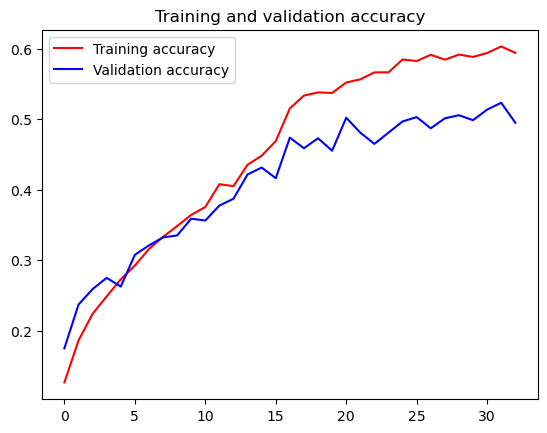

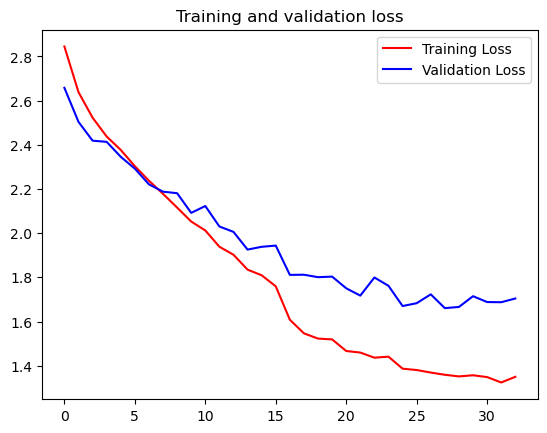

In [22]:
# Plot the chart for accuracy and loss on both training and validation
acc = history1.history['accuracy']
val_acc = history1.history['val_accuracy']
loss = history1.history['loss']
val_loss = history1.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [23]:
predictions = model_transfer.predict(validation_generator)
predictions=np.argmax(predictions,axis=-1)
print(predictions[:10])
print(validation_generator.labels[:10])

32/32 [==============================] - 71s 2s/step
[ 0 13 12 13  0  5  0  0  0  0]
[0 0 0 0 0 0 0 0 0 0]


In [24]:
dict_cls = validation_generator.class_indices


#  Evaluating  Precision, Recall, F1-Score and Support for the Model

In [25]:
print(classification_report(validation_generator.labels, predictions, target_names = list(dict_cls.keys())))

              precision    recall  f1-score   support

        Audi       0.46      0.50      0.48        54
     Bentley       0.39      0.46      0.42        68
        Benz       0.47      0.38      0.42        42
         Bmw       0.43      0.43      0.43        46
    Cadillac       0.48      0.44      0.46        64
       Dodge       0.57      0.55      0.56        62
     Ferrari       0.54      0.63      0.58        59
        Ford       0.52      0.52      0.52        62
Ford mustang       0.46      0.39      0.42        72
         Kia       0.45      0.43      0.44        60
 Lamborghini       0.56      0.64      0.59        69
       Lexus       0.45      0.45      0.45        66
    Maserati       0.49      0.54      0.52        70
     Porsche       0.41      0.47      0.44        51
 Rolls royce       0.58      0.62      0.60        64
       Tesla       0.61      0.53      0.57        43
      Toyota       0.55      0.56      0.55        52
  alfa romeo       0.49    

# Plotting the Confusion Matrix for the Classification

<AxesSubplot:>

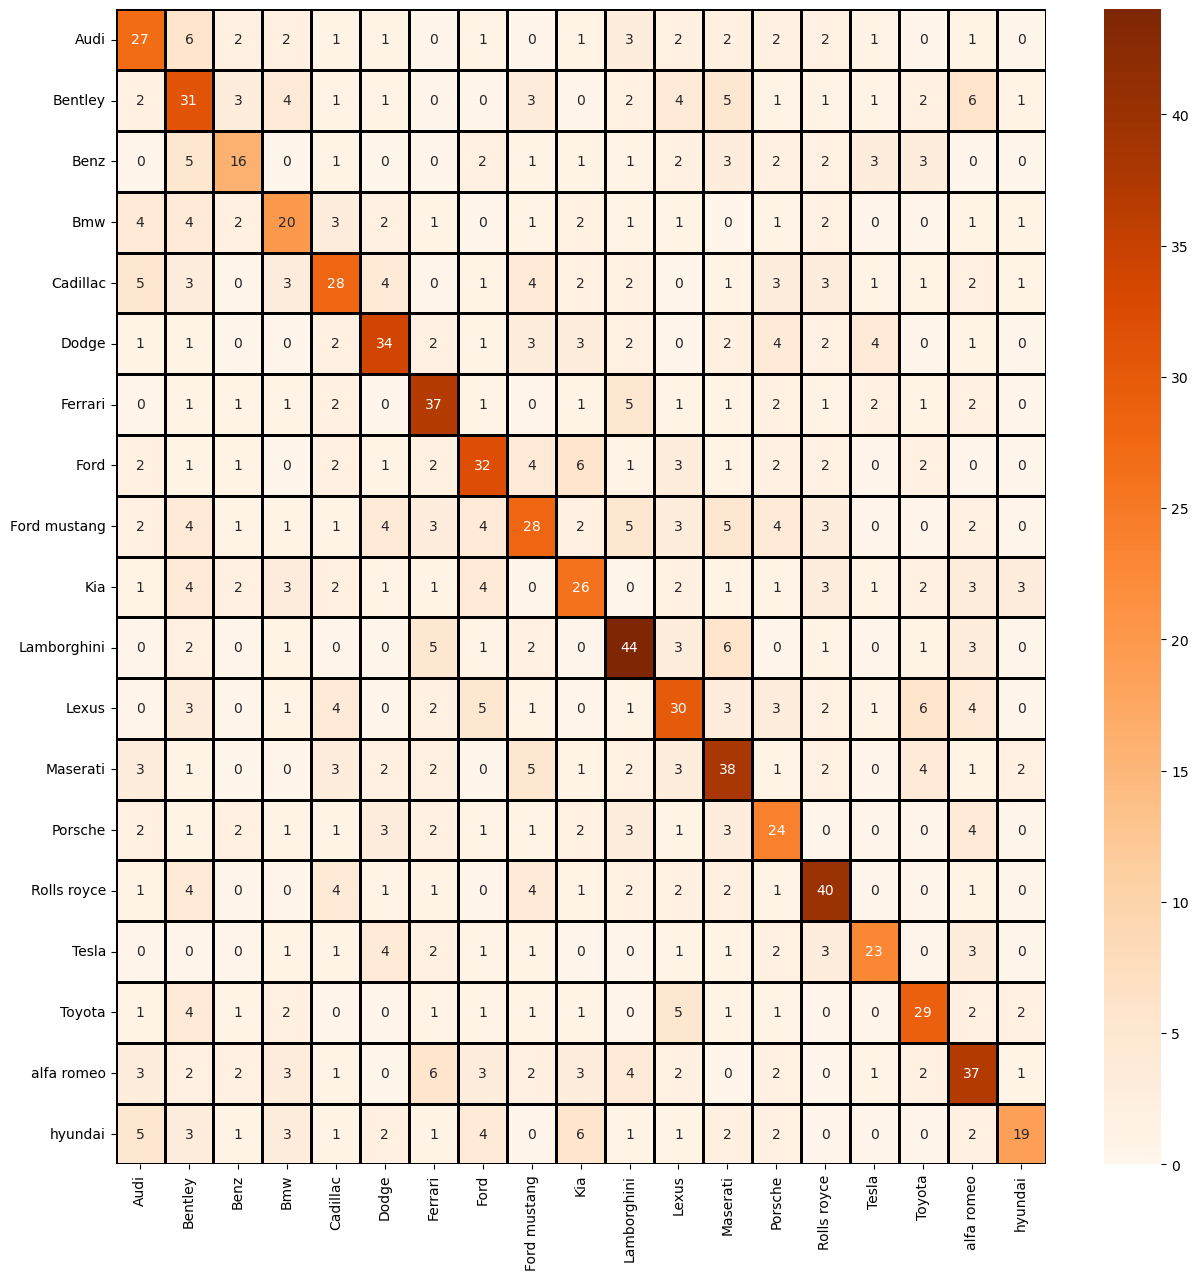

In [26]:
cm = confusion_matrix(validation_generator.labels,predictions)
cm = pd.DataFrame(cm , index = list(dict_cls.keys()) , columns = list(dict_cls.keys()))
plt.figure(figsize = (15,15))
sns.heatmap(cm,cmap= "Oranges", linecolor = 'black' , linewidth = 1 , annot = True, fmt='')

# Sample Model Prediction

In [27]:
def class_name(id):
    key_list = list(dict_cls.keys())
    val_list = list(dict_cls.values())
    position = val_list.index(id)
    return key_list[position]
    

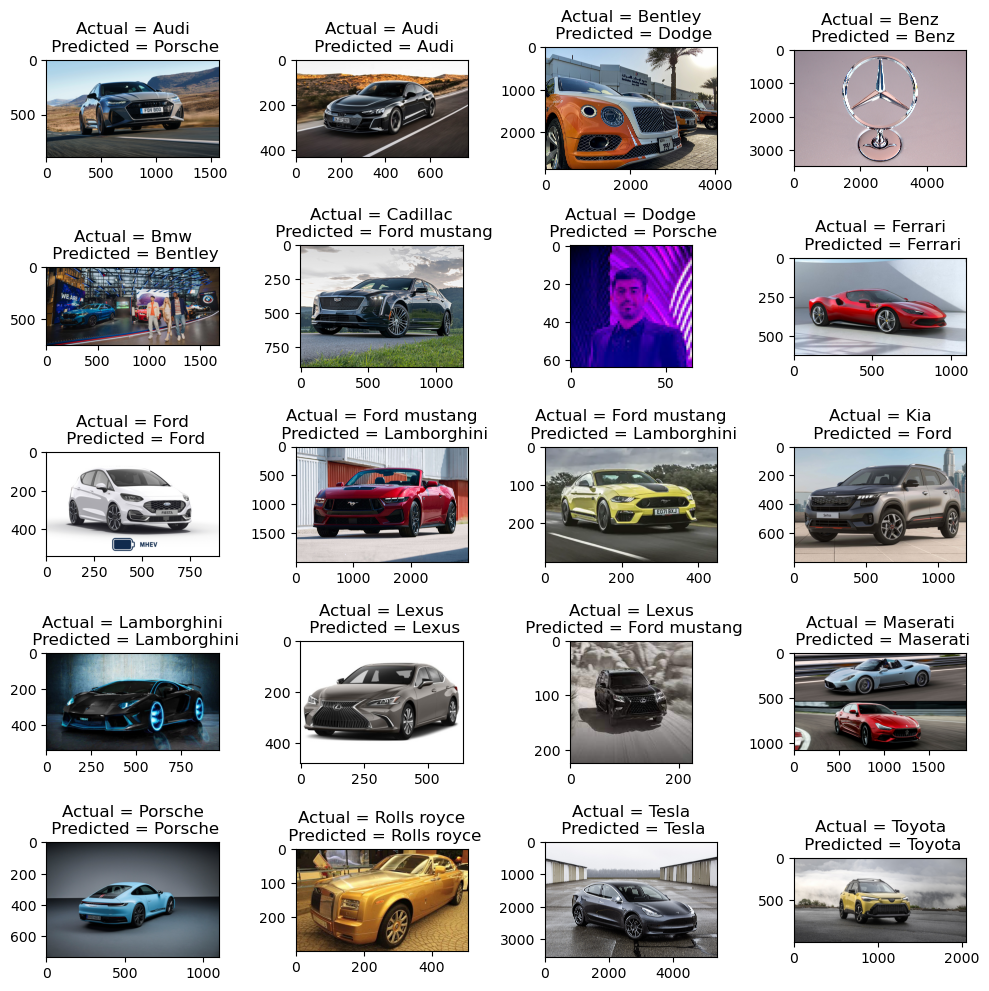

In [30]:
f, ax = plt.subplots(5,4) 
f.set_size_inches(10, 10)
k = 1
for i in range(5):
    for j in range(4):
        true_cls = validation_generator.labels[k]
        true_cls = class_name(true_cls)
        pred_cls = predictions[k]
        pred_cls = class_name(pred_cls)
        ax[i,j].set_title(f'Actual = {true_cls}\n Predicted = {pred_cls}')
        path = DIR + '/' + validation_generator.filenames[k]
        img=plt.imread(path)
        ax[i,j].imshow(img)
        k += 51
    plt.tight_layout() 